## CLIP ViT-B/32 Image-Text Retrieval

In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import clip
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
print("Device:", device)
model, preprocess = clip.load("ViT-B/32", device=device)

Device: mps


### Dataloder for 20 (pre-selected) PACS images

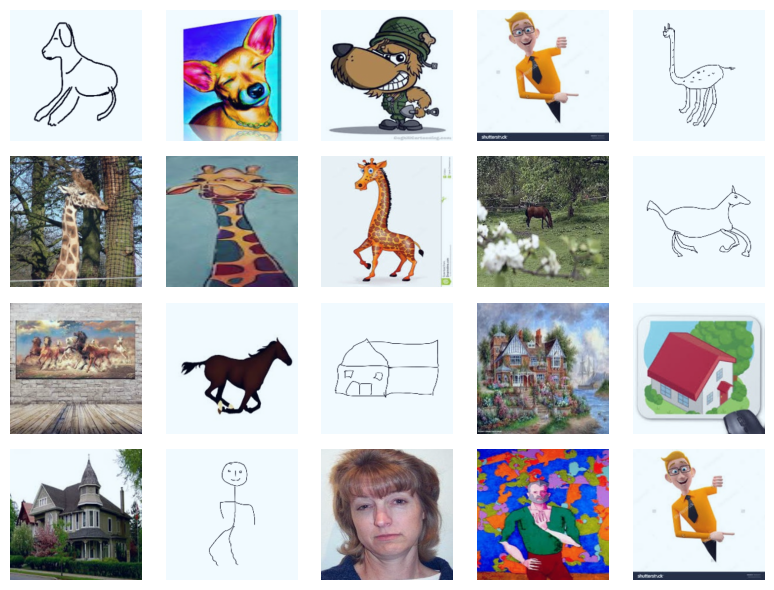

In [11]:
root_dir = 'data/20_pacs_custom'

dataset = datasets.ImageFolder(root=root_dir, transform=preprocess)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
)

imgs, labels = next(iter(loader))
imgs = imgs.permute(0,2,3,1).cpu().numpy()
imgs = (imgs - imgs.min()) / (imgs.max() - imgs.min())
plt.figure(figsize=(8, 6))
for i in range(len(imgs)):
    plt.subplot(4, 5, i+1)
    plt.imshow(imgs[i])
    # plt.title(dataset.classes[labels[i].item()], fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Image embeddings

In [4]:
all_image_features = []
all_labels = []
all_images = []
with torch.no_grad():
    for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features)
            all_labels.append(labels)
            all_images.append(images)

all_image_features = torch.cat(all_image_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_images = torch.cat(all_images, dim=0)


### Text (Query) Embeddings

In [5]:
queries = [
    'a photo of a house',
    'a painting of a horse',
    'a sketch of a person',
    'a cartoon of a dog',
    'a painting of a dog'
]

with torch.no_grad():
    text_tokens = clip.tokenize(queries).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

### Retrieval

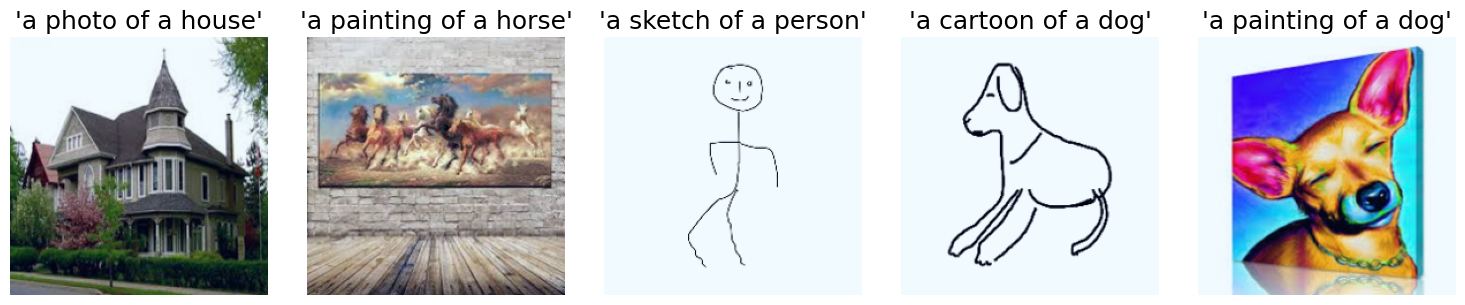

In [14]:
sims = text_features @ all_image_features.T

topk_values, topk_indices = sims.topk(1, dim=-1)

plt.figure(figsize=(3*len(queries), 3))

for qi, q in enumerate(queries):
    idx = topk_indices[qi].item()
    img = all_images[idx].permute(1,2,0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.subplot(1, len(queries), qi+1)
    plt.imshow(img)
    plt.title(f"'{q}'", fontsize=18)
    plt.axis("off")

plt.tight_layout()
plt.show()